In [27]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
#from netCDF4 import Dataset
import matplotlib
from datetime import datetime, timedelta, time
import glob
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering
import global_settings as gs
import pandas as pd
#import ARLreader as Ar
import preprocessing as prep
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline


'''set day'''
day_date = datetime(2017,9,1)

'''set station'''
haifa_station = gs.Station('haifa')
print(haifa_station)

<class 'global_settings.Station'>: {'name': 'haifa', 'location': 'haifa', 'lon': 35.0, 'lat': 32.8, 'altitude': 229, 'start_bin_height': 8.75, 'end_bin_height': 22485.66015, 'n_bins': 3000, 'dt': 5.0000000000000004e-08, 'gdas1_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\GDAS\\haifa', 'gdastxt_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\GDAS\\haifa_preproc', 'lidar_src_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS'}


C:\Users\addalin\Dropbox\Lidar\code\global_settings.py:53: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  stations_df = pd.read_csv(stations_csv_path, index_col='station_name', sep=', ')


In [28]:
'''Set paths for small tests'''
#lidar_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\data\level1a\PollyXT_TROPOS'
#gdas_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\GDAS\haifa'
lidar_parent_folder = haifa_station.lidar_src_folder
haifa_station.gdas1_folder = os.path.join('.','data examples','gdas')
haifa_station.gdastxt_folder  = os.path.join('.','data examples','gdas_txt')

In [29]:
#gdas1_folder,gdas1_paths = prep.get_gdas_paths(haifa_station, day_date,'gdas1')
#print('gdas1',gdas1_paths)

#convert cur day (gdas files from TROPOS to txt)
gdastxt = prep.convert_daily_gdas ( haifa_station, day_date)
print('gdas_txt',gdastxt)

#convert next day (gdas files from TROPOS to txt)
next_day = day_date + timedelta ( days = 1 )
gdastxt_nextday = prep.convert_daily_gdas ( haifa_station, next_day )
# gdastxt.extend(prep.convert_daily_gdas ( next_day , haifa_station ))
print('gdas_txt next day',gdastxt_nextday)


gdas_txt ['.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_00_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_03_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_06_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_09_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_12_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_15_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_18_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_21_32.8_35.0.txt']
gdas_txt next day ['.\\data examples\\gdas_txt\\2017\\09\\haifa_20170902_00_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170902_03_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170902_06_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170902_09_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170902_12_32.8_35.0.txt', '.\\data examples\\gda

<Figure size 432x288 with 0 Axes>

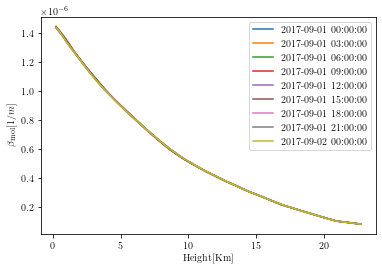

In [30]:
'''set parameters'''
lambda_nm = gs.LAMBDA_nm().G
df_sigma , df_beta = prep.get_daily_molecular_profiles( haifa_station , day_date , lambda_nm , 'Km' )
# Visualizing molecular profiles

plt.figure()
ax = df_beta.plot()
ax.set_ylabel(r'$\beta_{\rm mol}[1/m]$')
plt.show()

In [31]:
def generate_daily_att_bsc_mol(station, day_date, lambda_nm, time_res='30S', height_units ='Km'):
	"""	 """

	'''Load daily gdas profiles and convert to backscatter (beta) and extinction (sigma) profiles'''

	df_sigma , df_beta = prep.get_daily_molecular_profiles ( station , day_date , lambda_nm , height_units )

	''' Interpolate profiles through 24 hrs'''
	interp_sigma_df=(df_sigma.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_beta_df=(df_beta.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_sigma_df.columns.freq = None
	interp_beta_df.columns.freq = None

	'''Calculate the molecular attenuated backscatter as :  beta_mol * exp(-2*tau_mol)'''
	e_tau_df = interp_sigma_df.apply(prep.cal_e_tau_df,0,args=(haifa_station.altitude,),result_type='expand')
	#print ('e_tau ',e_tau_df)
	att_bsc_mol_df = interp_beta_df.multiply(e_tau_df)
	att_bsc_mol_df.rename_axis ('Height[{}]'.format ( height_units ) )

	import xarray as xr
	#print(lambda_nm)
	ds = xr.Dataset(
        data_vars   =   {  'beta'   :   (('Height', 'Time'), interp_beta_df),
                           'sigma'  :   (('Height', 'Time'), interp_sigma_df),
                           'att-bsc':   (('Height', 'Time'), att_bsc_mol_df)
                        },
        coords  =   {   'Height': interp_beta_df.index.to_list(),
                        'Time': interp_beta_df.columns,
                        'wavelen': lambda_nm
                        }
	)
	ds.beta.attrs =  {'long_name':r'$\beta$',  'units':r'$1/m \cdot sr$'}
	ds.sigma.attrs = {'long_name':r'$\sigma$', 'units':r'$1/m sr$'}
	ds.Height.attrs= {'units':'Km'}
	ds.wavelen.attrs ={'long_name':r'$\lambda$', 'units':r'$nm$'}

	return ds


In [32]:
import xarray as xr
print('ds_mol_rgb')
#lambda_nm = gs.LAMBDA_nm().G
ds_list = []
for lambda_nm in gs.LAMBDA_nm().get_elastic():
	ds_chan =generate_daily_att_bsc_mol( haifa_station, day_date, lambda_nm,time_res='30S')
	ds_list.append(ds_chan)

ds_mol_rgb
355
532
1064


In [33]:
ds=xr.concat(ds_list,dim ='wavelen')

In [34]:
ds

<xarray.Dataset>
Dimensions:  (Height: 3000, Time: 2880, wavelen: 3)
Coordinates:
  * Height   (Height) float64 0.2378 0.2452 0.2527 0.2602 ... 22.7 22.71 22.71
  * Time     (Time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30
  * wavelen  (wavelen) int64 355 532 1064
Data variables:
    beta     (wavelen, Height, Time) float64 7.72e-06 7.72e-06 ... 5.057e-09
    sigma    (wavelen, Height, Time) float64 6.564e-05 6.564e-05 ... 4.294e-08
    att-bsc  (wavelen, Height, Time) float64 7.955e-06 7.955e-06 ... 5.058e-09

test1
<xarray.DataArray 'wavelen' ()>
array(1064)
Coordinates:
    wavelen  int32 1064
Attributes:
    long_name:  $\lambda$
    units:      $nm$


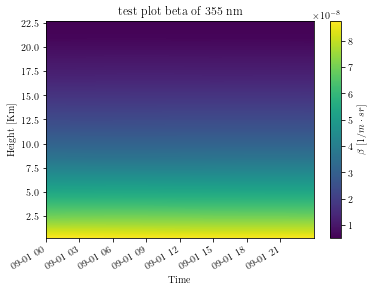

In [36]:
print('test1')
print(ds_chan.wavelen)

plt.figure()
ds_chan.beta.plot()
plt.title('test plot beta of 355 nm')
plt.show()

In [37]:
vars = list(ds_chan.data_vars)
ds_chan[vars[0]]

<xarray.DataArray 'beta' (Height: 3000, Time: 2880)>
array([[8.75826360e-08, 8.75825219e-08, 8.75824077e-08, ...,
        8.71362859e-08, 8.71364398e-08, 8.71365937e-08],
       [8.75296610e-08, 8.75295440e-08, 8.75294271e-08, ...,
        8.70838308e-08, 8.70839787e-08, 8.70841266e-08],
       [8.74766642e-08, 8.74765444e-08, 8.74764246e-08, ...,
        8.70313551e-08, 8.70314970e-08, 8.70316390e-08],
       ...,
       [5.07750890e-09, 5.07752571e-09, 5.07754253e-09, ...,
        5.06724910e-09, 5.06721807e-09, 5.06718704e-09],
       [5.07229342e-09, 5.07231025e-09, 5.07232709e-09, ...,
        5.06199951e-09, 5.06196842e-09, 5.06193733e-09],
       [5.06707868e-09, 5.06709554e-09, 5.06711240e-09, ...,
        5.05675073e-09, 5.05671958e-09, 5.05668843e-09]])
Coordinates:
  * Height   (Height) float64 0.2378 0.2452 0.2527 0.2602 ... 22.7 22.71 22.71
  * Time     (Time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30
    wavelen  int32 1064
Attributes:
    long_name:  $\beta$
    units:      $1/m \cdot sr$

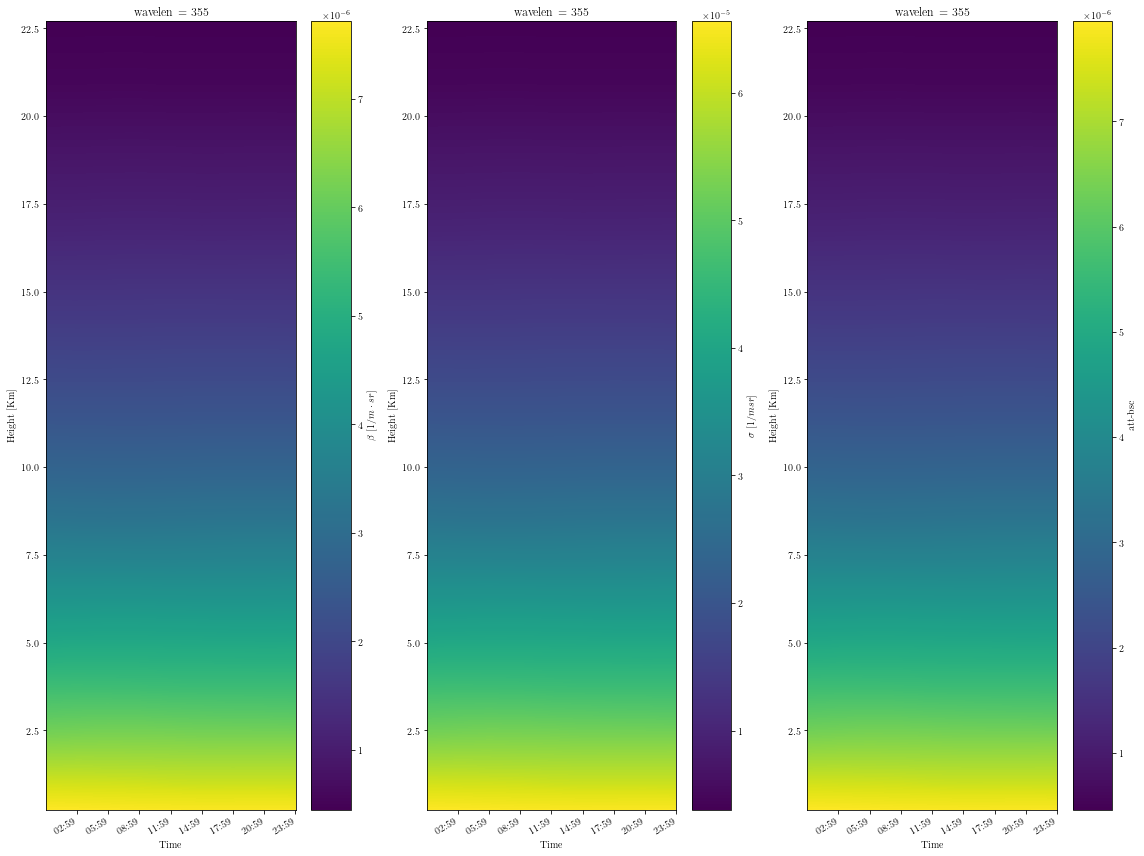

In [38]:
xfmt = mdates.DateFormatter('%H:%M')
fig, axes = plt.subplots(ncols = 3, figsize=(16,12)) #nrows = 3,
#for wav in  gs.LAMBDA_nm().get_elastic(): #TODO: iterating over nrow(for channel ) is not working
wav = 355
curds = ds.sel(wavelen=wav)
for (ax,dvar) in zip(axes,list(ds.data_vars)):
	#print(curds)
	curds[dvar].plot(ax=ax)
	ax.xaxis_date()
	ax.get_xaxis().set_major_locator(mdates.MinuteLocator(interval=180))
	ax.xaxis.set_major_formatter(xfmt)
#mol_xr.plot()
plt.tight_layout()
plt.show()

In [23]:
df_test_beta = curds.beta.to_pandas()
df_test_beta

Time,2017-09-01 00:00:00,2017-09-01 00:00:30,2017-09-01 00:01:00,2017-09-01 00:01:30,2017-09-01 00:02:00,2017-09-01 00:02:30,2017-09-01 00:03:00,2017-09-01 00:03:30,2017-09-01 00:04:00,2017-09-01 00:04:30,...,2017-09-01 23:55:00,2017-09-01 23:55:30,2017-09-01 23:56:00,2017-09-01 23:56:30,2017-09-01 23:57:00,2017-09-01 23:57:30,2017-09-01 23:58:00,2017-09-01 23:58:30,2017-09-01 23:59:00,2017-09-01 23:59:30
Height,,,,,,,,,,,,,,,,,,,,,
0.237750,7.719861e-06,7.719852e-06,7.719842e-06,7.719833e-06,7.719824e-06,7.719815e-06,7.719805e-06,7.719796e-06,7.719787e-06,7.719777e-06,...,7.681569e-06,7.681583e-06,7.681596e-06,7.681610e-06,7.681623e-06,7.681637e-06,7.681650e-06,7.681664e-06,7.681677e-06,7.681691e-06
0.245245,7.715188e-06,7.715179e-06,7.715169e-06,7.715160e-06,7.715150e-06,7.715141e-06,7.715131e-06,7.715122e-06,7.715112e-06,7.715103e-06,...,7.676944e-06,7.676957e-06,7.676970e-06,7.676983e-06,7.676996e-06,7.677009e-06,7.677022e-06,7.677035e-06,7.677048e-06,7.677061e-06
0.252740,7.710514e-06,7.710504e-06,7.710494e-06,7.710484e-06,7.710475e-06,7.710465e-06,7.710455e-06,7.710445e-06,7.710436e-06,7.710426e-06,...,7.672318e-06,7.672330e-06,7.672343e-06,7.672355e-06,7.672368e-06,7.672380e-06,7.672392e-06,7.672405e-06,7.672417e-06,7.672430e-06
0.260234,7.705837e-06,7.705827e-06,7.705817e-06,7.705807e-06,7.705797e-06,7.705787e-06,7.705777e-06,7.705767e-06,7.705757e-06,7.705747e-06,...,7.667689e-06,7.667701e-06,7.667713e-06,7.667725e-06,7.667737e-06,7.667749e-06,7.667761e-06,7.667773e-06,7.667785e-06,7.667797e-06
0.267729,7.701159e-06,7.701148e-06,7.701138e-06,7.701128e-06,7.701118e-06,7.701107e-06,7.701097e-06,7.701087e-06,7.701077e-06,7.701066e-06,...,7.663059e-06,7.663070e-06,7.663082e-06,7.663093e-06,7.663104e-06,7.663116e-06,7.663127e-06,7.663139e-06,7.663150e-06,7.663162e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22.684681,4.481957e-07,4.481972e-07,4.481987e-07,4.482001e-07,4.482016e-07,4.482031e-07,4.482046e-07,4.482060e-07,4.482075e-07,4.482090e-07,...,4.473170e-07,4.473143e-07,4.473116e-07,4.473088e-07,4.473061e-07,4.473034e-07,4.473007e-07,4.472979e-07,4.472952e-07,4.472925e-07
22.692176,4.477361e-07,4.477376e-07,4.477391e-07,4.477406e-07,4.477421e-07,4.477435e-07,4.477450e-07,4.477465e-07,4.477480e-07,4.477495e-07,...,4.468545e-07,4.468517e-07,4.468490e-07,4.468463e-07,4.468436e-07,4.468408e-07,4.468381e-07,4.468354e-07,4.468326e-07,4.468299e-07
22.699671,4.472766e-07,4.472781e-07,4.472796e-07,4.472811e-07,4.472826e-07,4.472841e-07,4.472855e-07,4.472870e-07,4.472885e-07,4.472900e-07,...,4.463920e-07,4.463893e-07,4.463865e-07,4.463838e-07,4.463811e-07,4.463783e-07,4.463756e-07,4.463729e-07,4.463701e-07,4.463674e-07


In [24]:
#format_time = '%Y-%m-%d %H:%M:%S'
start_time = datetime(2017,9,1,0,30)
end_time = start_time + timedelta(hours = 6) #datetime(2017,9,1,12,30)
timestamps = pd.date_range ( start = start_time , end = end_time  ,
                             freq = timedelta ( seconds = 30 ) )
#slice_beta= mol_xr.loc['beta'].to_pandas().loc[:,timestamps]
print('slicing data set by time')
sub_ds = curds.sel(Time =slice(start_time,end_time))#  timestamps).plot()#=slice(start_time,start_time+timedelta(hours = 6)))

sub_ds

slicing data set by time


<xarray.Dataset>
Dimensions:  (Height: 3000, Time: 721)
Coordinates:
  * Height   (Height) float64 0.2378 0.2452 0.2527 0.2602 ... 22.7 22.71 22.71
  * Time     (Time) datetime64[ns] 2017-09-01T00:30:00 ... 2017-09-01T06:30:00
    wavelen  int64 355
Data variables:
    beta     (Height, Time) float64 7.719e-06 7.719e-06 ... 4.478e-07 4.478e-07
    sigma    (Height, Time) float64 6.564e-05 6.564e-05 ... 3.809e-06 3.809e-06
    att-bsc  (Height, Time) float64 7.955e-06 7.955e-06 ... 4.609e-07 4.609e-07

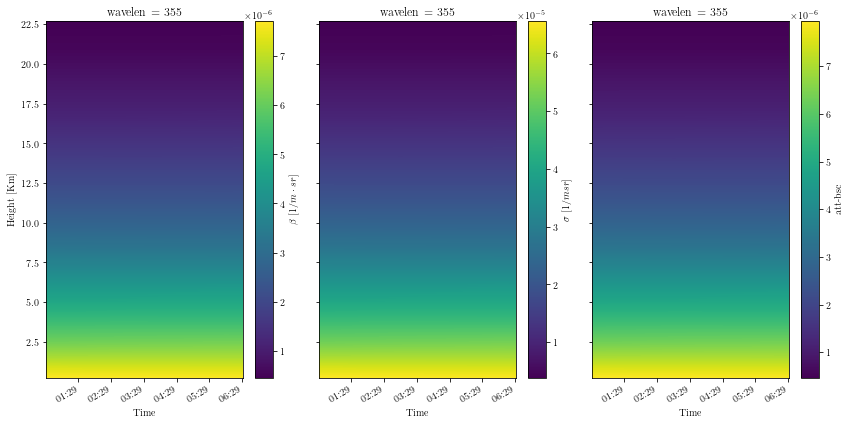

In [25]:
fig, axes = plt.subplots(ncols=3,figsize=(12,6),sharey = 'row')
ind=0
for ind,(ax,dvar) in enumerate(zip(axes,list(curds.data_vars))):
	sub_ds[dvar].plot(ax=ax)
	if ind>0:
		ax.set_ylabel('')
	ax.xaxis_date()
	ax.get_xaxis().set_major_locator(mdates.MinuteLocator(interval=60))
	ax.xaxis.set_major_formatter(xfmt)
plt.tight_layout()
plt.show()

In [ ]:
cur_df= curds.beta
x_lims = mdates.date2num([cur_df.columns[0],cur_df.columns[-1]])
y_lims = [cur_df.index[0]*1E-3, cur_df.index[-1]*1E-3]
extent = [x_lims[0],x_lims[1],y_lims[0],y_lims[1] ]
fig, ax = plt.subplots(figsize=(16,15))
im = ax.imshow(cur_df, origin='lower',aspect='auto',cmap = 'turbo',
               extent=extent)#[0,2779,interp_sigma_df.index[0], interp_sigma_df.index[-1]])

ax.set_ylabel('Altitude [km]',fontsize = 24)
ax.set_xlabel('Time',fontsize = 24)
plt.rc('xtick',labelsize = 18)
plt.rc('ytick',labelsize = 18)
fig.colorbar(im,ax= ax)
ax.xaxis_date()
ax.get_xaxis().set_major_locator(mdates.MinuteLocator(interval=120))
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
fig.tight_layout()
plt.show()

In [ ]:
# TODO: mol_xr: define attributes of as station name , altitude, Height units,
# TODO: create xarray to a daily molecular profile for three channels (UV,G,IR)
# TODO: save xarray as netcd file according to day_date paths
# TODO: convert from xarray to pytorch

# TODO: validate units of height, speed of light, sigma and beta !!! (km or m)

# TODO: create table of profiles (for the data loader)

# TODO: Create samples of 30 min acording to 'profiles' times
# for the followings :
# X = {lidar measurement (range corrected) molecular (range corrected)}
# Y = {lidar const, reference height [min,max]}

## AERONET : https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=Technion_Haifa_IL&nachal=0&year=2017&month=5&day=19&aero_water=0&level=3&if_day=0&if_err=0&place_code=10&DATA_TYPE=-999&year_or_month=3
## it is possible to merge with Terra MODIS or Aqua MODIS -
# / TODO: locate the function that does donwload of sunphotometer data to cameranetwork (maybe Shubi knows this)
# / TODO: ask about the relevant product from MODIS to our porpose.



In [ ]:
bsc_paths, profile_paths = prep.load_att_bsc(lidar_parent_folder, day_date)
bsc_paths
profile_paths


In [ ]:
start_day =  datetime(2019,4,3)
end_day = datetime(2019,4,20)
chunk_paths = prep.convert_periodic_gdas(haifa_station,start_day, end_day)
